In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Import Data

In [85]:
adata = ad.read_h5ad('/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_zscore.h5ad')
adata.X = adata.layers['log1p_norm'].copy()

In [35]:
# replace linker-1 and linker-2 with just linker
adata.obs['ligand_call_oBC_CR'] = adata.obs['ligand_call_oBC_CR'].str.replace(
    r'linker-(1|2)', 'linker', regex=True)
print(adata.obs['ligand_call_oBC_CR'].unique())

['IL4_linker' 'IL4_IL12' 'IL12_IFNA' 'IL4_IFNA' 'IL12_linker' 'IL12_IL6'
 'IL2_TNF' 'IL21_linker' 'IFNA_linker' 'IL2_linker' 'IL2_IL6' 'IL4_IL6'
 'TNF_linker' 'IL2_IL12' 'IL2_IL4' 'IFNA_TNF' 'IL6_linker' 'IL4_IL21'
 'IL4_IL27' 'linker_linker' 'IL27_linker' 'IL27_TNF' 'IFNA_IL27'
 'IL6_IL21' 'IL2_IL27' 'IL4_TNF' 'IL6_TNF' 'IL2_IL21' 'IL6_IFNA'
 'IL6_IL27' 'IL2_IFNA' 'IL21_TNF' 'IFNA_IL21' 'IL21_IL27' 'IL12_TNF'
 'IL12_IL27' 'IL12_IL21']


In [37]:
# print number of cells per category
adata.obs['ligand_call_oBC_CR'].value_counts()

ligand_call_oBC_CR
TNF_linker       6643
IL4_linker       6527
IL2_linker       5895
IL27_linker      5523
IL6_linker       4026
IFNA_linker      3986
IL21_linker      3345
linker_linker    3111
IL4_TNF          2795
IL2_TNF          2769
IL27_TNF         2709
IL2_IL4          2619
IL12_linker      2617
IL4_IL27         2157
IL2_IL27         2149
IFNA_TNF         2064
IL6_TNF          1950
IL2_IL6          1900
IL2_IFNA         1834
IL4_IFNA         1827
IL4_IL6          1815
IFNA_IL27        1747
IL6_IL27         1711
IL21_TNF         1481
IL2_IL21         1443
IL12_IL27        1424
IL4_IL21         1413
IL12_TNF         1359
IFNA_IL21        1286
IL4_IL12         1269
IL6_IFNA         1175
IL12_IFNA        1101
IL21_IL27        1075
IL6_IL21          947
IL2_IL12          844
IL12_IL21         818
IL12_IL6          572
Name: count, dtype: int64

# Scanpy DEG

First, we'll use a simple non-parametric wilcoxon test to calculate DEGs. Starting with the simple first.

In [9]:
warnings.simplefilter(action='ignore',category=pd.errors.PerformanceWarning)
sc.tl.rank_genes_groups(adata, 'ligand_call_oBC_CR',
                        reference='linker_linker',
                        method='wilcoxon',
                        pts=True)

In [13]:
degWilcox = sc.get.rank_genes_groups_df(adata, group=None)
degWilcoxSig = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=0.1)

In [14]:
degWilcox.to_csv("/data/rudensky/EYW/git_projects/SIG07/analysis_outs/deg_wilcoxon.csv")
degWilcoxSig.to_csv("/data/rudensky/EYW/git_projects/SIG07/analysis_outs/deg_sig_wilcoxon.csv")

In [15]:
degWilcox

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group
0,IFNA_IL21,Isg15,49.412685,6.643268,0.0,0.0,0.962675
1,IFNA_IL21,Zbp1,49.240025,3.773547,0.0,0.0,0.991446
2,IFNA_IL21,Ifit3,49.117832,7.043824,0.0,0.0,0.956454
3,IFNA_IL21,Stat1,49.020500,3.406465,0.0,0.0,0.993779
4,IFNA_IL21,Rnf213,48.447807,4.917690,0.0,0.0,0.960342
...,...,...,...,...,...,...,...
375835,TNF_linker,Ighm,-40.574741,-1.111760,0.0,0.0,0.921120
375836,TNF_linker,Sh2d2a,-41.809788,-1.661366,0.0,0.0,0.568418
375837,TNF_linker,Selenop,-42.546642,-1.387298,0.0,0.0,0.776456
375838,TNF_linker,S1pr1,-44.089268,-1.627957,0.0,0.0,0.561042


In [25]:
import pandas as pd

def calculate_logFC_and_compare(df, group_a, group_b, p_val=0.1):
    """
    Calculate logFC of group A + logFC of group B and compare to logFC of group C.
    Include all genes significant in A, B, or C.

    Args:
    df (pd.DataFrame): DataFrame containing the data with columns ['group', 'names', 'logfoldchanges', 'pvals_adj'].
    group_a (str): Category name for group A.
    group_b (str): Category name for group B.

    Returns:
    pd.DataFrame: DataFrame with calculated values and significance comparison.
    """
    # Derive group C
    ligands = sorted([group_a, group_b])
    possible_group_c = [f"{ligands[0]}_{ligands[1]}", f"{ligands[1]}_{ligands[0]}"]
    # Check which of the possible group C values exists in the dataset
    group_c = next((group for group in possible_group_c if group in df['group'].unique()), None)
    if group_c is None:
        raise ValueError(f"Neither '{possible_group_c[0]}' nor '{possible_group_c[1]}' found in the dataset.")

    # Filter DataFrame for groups A, B, and C
    df_a = df[df['group'] == f"{group_a}_linker"].set_index('names')
    df_b = df[df['group'] == f"{group_b}_linker"].set_index('names')
    df_c = df[df['group'] == group_c].set_index('names')

    # Merge dataframes to align genes
    merged = df_a[['logfoldchanges', 'pvals_adj']].rename(columns={'logfoldchanges': f"logFC_{group_a}", 'pvals_adj': f"pvals_adj_{group_a}"}).join(
        df_b[['logfoldchanges', 'pvals_adj']].rename(columns={'logfoldchanges': f"logFC_{group_b}", 'pvals_adj': f"pvals_adj_{group_b}"}), how='outer'
    ).join(
        df_c[['logfoldchanges', 'pvals_adj']].rename(columns={'logfoldchanges': f"logFC_{group_c}", 'pvals_adj': f"pvals_adj_{group_c}"}), how='outer'
    )

    # Calculate logFC_A + logFC_B
    merged['logFC_expected'] = merged[f"logFC_{group_a}"] + merged[f"logFC_{group_b}"]
    
    # Calculate comparison logFC_C - (logFC_A + logFC_B)
    merged['logFC_difference'] = merged[f"logFC_{group_c}"] - merged['logFC_expected']
    
    # Determine significance
    # Filter for significant genes
    merged['significant'] = merged[[f"pvals_adj_{group_a}", f"pvals_adj_{group_b}", f"pvals_adj_{group_c}"]].min(axis=1) < p_val
    significant_genes = merged[merged['significant']].drop(columns='significant')
    
    return significant_genes.reset_index()

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def calculate_logFC_and_plot(df, group_a, group_b, p_val=0.1):
    """
    Calculate logFC of group A + logFC of group B and compare to logFC of group C.
    Include all genes significant in A, B, or C.

    Args:
    df (pd.DataFrame): DataFrame containing the data with columns ['group', 'names', 'logfoldchanges', 'pvals_adj'].
    group_a (str): Category name for group A.
    group_b (str): Category name for group B.

    Returns:
    pd.DataFrame: DataFrame with calculated values and significance comparison.
    """
    # Derive group C
    ligands = sorted([group_a, group_b])
    possible_group_c = [f"{ligands[0]}_{ligands[1]}", f"{ligands[1]}_{ligands[0]}"]
    # Check which of the possible group C values exists in the dataset
    group_c = next((group for group in possible_group_c if group in df['group'].unique()), None)
    if group_c is None:
        raise ValueError(f"Neither '{possible_group_c[0]}' nor '{possible_group_c[1]}' found in the dataset.")

    # Filter DataFrame for groups A, B, and C
    df_a = df[df['group'] == f"{group_a}_linker"].set_index('names')
    df_b = df[df['group'] == f"{group_b}_linker"].set_index('names')
    df_c = df[df['group'] == group_c].set_index('names')

    # Merge dataframes to align genes
    merged = df_a[['logfoldchanges', 'pvals_adj', 'pct_nz_group']].rename(
        columns={
            'logfoldchanges': f"logFC_{group_a}",
            'pvals_adj': f"pvals_adj_{group_a}",
            'pct_nz_group': f"pct_nz_{group_a}"
        }).join(
        df_b[['logfoldchanges', 'pvals_adj', 'pct_nz_group']].rename(
            columns={
                'logfoldchanges': f"logFC_{group_b}",
                'pvals_adj': f"pvals_adj_{group_b}",
                'pct_nz_group': f"pct_nz_{group_b}"
            }), how='outer'
    ).join(
        df_c[['logfoldchanges', 'pvals_adj', 'pct_nz_group']].rename(
            columns={
                'logfoldchanges': f"logFC_{group_c}",
                'pvals_adj': f"pvals_adj_{group_c}",
                'pct_nz_group': f"pct_nz_{group_c}"
            }), how='outer'
    )

    # Calculate logFC_A + logFC_B
    merged['logFC_expected'] = merged[f"logFC_{group_a}"] + merged[f"logFC_{group_b}"]
    
    # Calculate comparison logFC_C - (logFC_A + logFC_B)
    merged['logFC_difference'] = merged[f"logFC_{group_c}"] - merged['logFC_expected']
    
    # Determine significance
    # Filter for significant genes
    merged['significant'] = merged[[f"pvals_adj_{group_a}", f"pvals_adj_{group_b}", f"pvals_adj_{group_c}"]].min(axis=1) < p_val
    significant_genes = merged[merged['significant']].drop(columns='significant')
    
    # Create a scatter plot
    plt.figure(figsize=(5, 5))
    
    # Define color scale limits centered around 0
    color_min = significant_genes['logFC_difference'].min()
    color_max = significant_genes['logFC_difference'].max()
    abs_max = max(abs(color_min), abs(color_max))
    
    sns.scatterplot(
        x=significant_genes['logFC_expected'],
        y=significant_genes[f"logFC_{group_c}"],
        hue=significant_genes['logFC_difference'],  # Color by the difference
        palette='coolwarm',
        hue_norm=(-abs_max, abs_max),  # Force the color scale to be symmetric around 0
        alpha=0.7
    )
    plt.axline((0, 0), slope=1, color='grey', linestyle='--', linewidth=1)  # Add y=x reference line
    plt.title(f'Scatter Plot: logFC_expected vs. logFC_{group_c}')
    plt.xlabel(f'logFC_expected ({group_a} + {group_b})')
    plt.ylabel(f'logFC_{group_c}')
    plt.legend(title='Difference', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return significant_genes.reset_index()

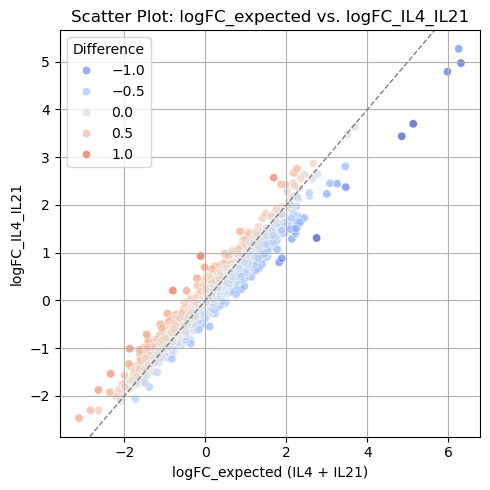

,names,logFC_IL4,pvals_adj_IL4,pct_nz_IL4,logFC_IL21,pvals_adj_IL21,pct_nz_IL21,logFC_IL4_IL21,pvals_adj_IL4_IL21,pct_nz_IL4_IL21,logFC_expected,logFC_difference
1593,Frmd6,0.254410,8.257385e-03,0.265972,-0.373171,3.338858e-02,0.192526,0.928413,6.542771e-18,0.389243,-0.118761,1.047174
4755,Trib3,-0.305514,3.400761e-02,0.171901,-0.500370,2.950532e-03,0.152167,0.203055,4.968478e-01,0.218684,-0.805885,1.008939
1620,Gadd45g,0.203871,1.916597e-01,0.123487,1.482297,1.401421e-18,0.229596,2.568558,3.538604e-64,0.407643,1.686168,0.882390
1295,Eif2ak3,-1.123133,5.411761e-51,0.290179,-0.749513,8.028553e-20,0.336622,-1.015203,8.646559e-20,0.311394,-1.872646,0.857443
452,Bbc3,-1.616008,4.341375e-78,0.174659,-0.725964,4.887341e-18,0.275934,-1.541111,2.246936e-34,0.182590,-2.341972,0.800861
...,...,...,...,...,...,...,...,...,...,...,...,...
4959,Unc93b1,-0.457654,6.279587e-02,0.119810,-0.444910,2.007411e-01,0.121076,NaN,NaN,NaN,-0.902563,NaN
5010,Utp20,0.428610,6.468443e-02,0.106328,NaN,NaN,NaN,0.615677,2.616947e-02,0.127389,NaN,NaN
5034,Vav3,-0.786428,7.665619e-05,0.100812,-0.770556,1.853094e-03,0.101943,NaN,NaN,NaN,-1.556985,NaN
5090,Wdr19,NaN,NaN,NaN,-0.489571,5.358569e-02,0.108819,NaN,NaN,NaN,NaN,NaN


In [77]:
calculate_logFC_and_plot(degWilcox[degWilcox['pct_nz_group']>0.1],
                         "IL4","IL21").sort_values('logFC_difference', ascending=False)

In [65]:
temp.to_csv("/data/rudensky/EYW/git_projects/SIG07/analysis_outs/temp.csv")

In [11]:
degSigSum = degSig['group'].value_counts()
degSigSum = degSigSum[degSigSum > 0]

In [103]:
adataPB = ad.read_h5ad("/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_log1p_mean_pseudobulk.h5ad")

In [104]:
adataPB.obs['ligand_call_oBC_CR'].value_counts()

ligand_call_oBC_CR
IL4_linker       3
IL4_IL6          3
TNF_linker       3
IL27_linker      3
IL27_TNF         3
IL6_linker       3
IL6_TNF          3
IL6_IL27         3
IL6_IFNA         3
IFNA_IL27        3
IL4_TNF          3
IL4_IL27         3
linker_linker    3
IL4_IFNA         3
IFNA_TNF         3
IL2_linker       3
IL2_TNF          3
IL2_IL27         3
IFNA_linker      3
IL2_IFNA         3
IL2_IL6          3
IL2_IL4          3
IL12_TNF         2
IL21_linker      2
IL21_TNF         2
IL21_IL27        2
IL12_linker      2
IL12_IL6         2
IL12_IL27        2
IL4_IL12         2
IL12_IFNA        2
IL2_IL12         2
IL6_IL21         2
IL2_IL21         2
IL4_IL21         2
IFNA_IL21        2
IL12_IL21        1
Name: count, dtype: int64

In [105]:
# Identify categories with exactly 3 cells
categories_to_keep = adataPB.obs['ligand_call_oBC_CR'].value_counts()
categories_to_keep = categories_to_keep[categories_to_keep > 1].index

# Filter the AnnData object to only include these categories
adataPB = adataPB[adataPB.obs['ligand_call_oBC_CR'].isin(categories_to_keep)].copy()

In [100]:
warnings.simplefilter(action='ignore',category=pd.errors.PerformanceWarning)
sc.tl.rank_genes_groups(adataPB, 'ligand_call_oBC_CR',
                        reference='linker_linker',
                        method='wilcoxon',
                        pts=True)

In [101]:
degPseudoWilcox = sc.get.rank_genes_groups_df(adataPB, group=None)
degPseudoWilcoxSig = sc.get.rank_genes_groups_df(adataPB, group=None, pval_cutoff=0.1)

In [102]:
degPseudoWilcoxSig = degPseudoWilcoxSig['group'].value_counts()
degPseudoWilcoxSig[degPseudoWilcoxSig > 0]

group
IL2_TNF        7401
IL4_TNF        7327
IL6_TNF        6895
IFNA_TNF       6402
IL2_IL4        6382
IL4_IFNA       6334
TNF_linker     6231
IL27_TNF       6131
IL4_IL6        6106
IL2_IL6        6100
IL2_IL27       6038
IL2_linker     5989
IL2_IFNA       5925
IL4_IL27       5811
IFNA_IL27      5777
IL4_linker     5662
IL6_linker     5495
IL6_IFNA       5475
IFNA_linker    5357
Name: count, dtype: int64

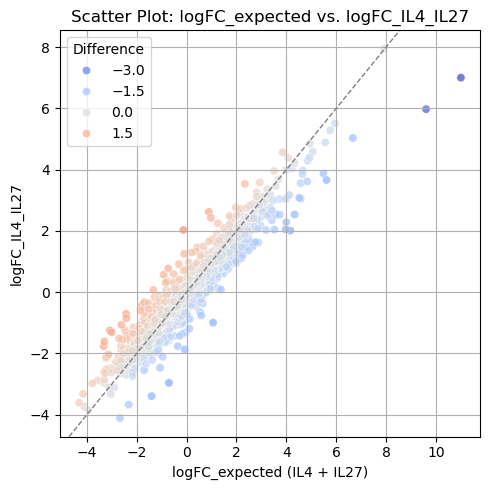

,names,logFC_IL4,pvals_adj_IL4,pct_nz_IL4,logFC_IL27,pvals_adj_IL27,pct_nz_IL27,logFC_IL4_IL27,pvals_adj_IL4_IL27,pct_nz_IL4_IL27,logFC_expected,logFC_difference
3318,Metrnl,1.756061,0.091335,1.0,-1.887232,0.126750,1.0,2.030855,0.088994,1.0,-0.131171,2.162026
4564,Pstpip2,-1.472818,0.091335,1.0,-1.606405,0.126750,1.0,-1.250851,0.088994,1.0,-3.079223,1.828373
108,Acvr1c,2.361314,0.091335,1.0,-1.469107,0.126750,1.0,2.621290,0.088994,1.0,0.892207,1.729083
5703,Syngr1,-1.017743,0.091335,1.0,-1.409580,0.126750,1.0,-0.707180,0.190961,1.0,-2.427324,1.720144
6276,Tubb3,-1.656134,0.091335,1.0,-1.348787,0.126750,1.0,-1.309024,0.088994,1.0,-3.004921,1.695898
...,...,...,...,...,...,...,...,...,...,...,...,...
3583,Nav1,3.773448,0.091335,1.0,0.386901,0.827259,1.0,2.010370,0.088994,1.0,4.160349,-2.149978
27,Abcc3,-0.931601,0.091335,1.0,0.223476,0.410315,1.0,-2.957565,0.088994,1.0,-0.708125,-2.249440
6083,Tns4,5.041616,0.091335,1.0,4.565881,0.126750,1.0,5.973419,0.088994,1.0,9.607497,-3.634078
5122,Serpina3g,4.565239,0.091335,1.0,6.437189,0.126750,1.0,7.002057,0.088994,1.0,11.002428,-4.000371


In [138]:
calculate_logFC_and_plot(degPseudoWilcox[degPseudoWilcox['pct_nz_group']>0],
                         "IL4","IL27").sort_values('logFC_difference', ascending=False)

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_gene_counts_boxplot(adata, group_a, group_b, gene):
    """
    Plot a boxplot with individual points for counts of a specific gene in an AnnData object, 
    always including the 'linker_linker' group.
    
    Parameters:
        adata: AnnData
            AnnData object containing data in .X, group information in `ligand_call_oBC_CR`, and gene names in `adata.var`.
        group_a: str
            Name of group A.
        group_b: str
            Name of group B.
        gene: str
            Gene name to plot counts for (must be in `adata.var.index`).
    
    Returns:
        pd.DataFrame:
            A DataFrame with individual counts for the specified gene and groups.
    """
    # Check if the gene exists in the dataset
    if gene not in adata.var.index:
        raise ValueError(f"Gene '{gene}' not found in `adata.var.index`.")
    
    # Derive group C
    ligands = sorted([group_a, group_b])
    possible_group_c = [f"{ligands[0]}_{ligands[1]}", f"{ligands[1]}_{ligands[0]}"]
    group_c = next((group for group in possible_group_c if group in adata.obs['ligand_call_oBC_CR'].unique()), None)
    if group_c is None:
        raise ValueError(f"Neither '{possible_group_c[0]}' nor '{possible_group_c[1]}' found in the dataset.")
    
    # Ensure 'linker_linker' is included
    groups_to_include = [f"{group_a}_linker", f"{group_b}_linker", group_c, 'linker_linker']
    
    # Extract counts for the specified gene and all groups
    gene_index = adata.var.index.get_loc(gene)  # Get the index of the gene
    group_data = []
    for group in groups_to_include:
        if group in adata.obs['ligand_call_oBC_CR'].unique():
            mask = adata.obs['ligand_call_oBC_CR'] == group
            counts = adata.X[mask, gene_index].flatten()
            group_data.append(pd.DataFrame({'Group': group, 'Count': counts}))
        else:
            # If group is not present, include it with zero counts
            group_data.append(pd.DataFrame({'Group': group, 'Count': []}))
    
    # Combine data into a single DataFrame
    plot_data = pd.concat(group_data, ignore_index=True)
    
    # Plot the boxplot with individual points
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=plot_data, x='Group', y='Count', color='lightblue', width=0.6, showfliers=False)
    sns.stripplot(data=plot_data, x='Group', y='Count', color='black', alpha=0.7, jitter=True)
    plt.title(f'Counts for {gene} per Group')
    plt.xlabel('Group')
    plt.ylabel('Gene Counts')
    plt.tight_layout()
    plt.show()
    
    return plot_data


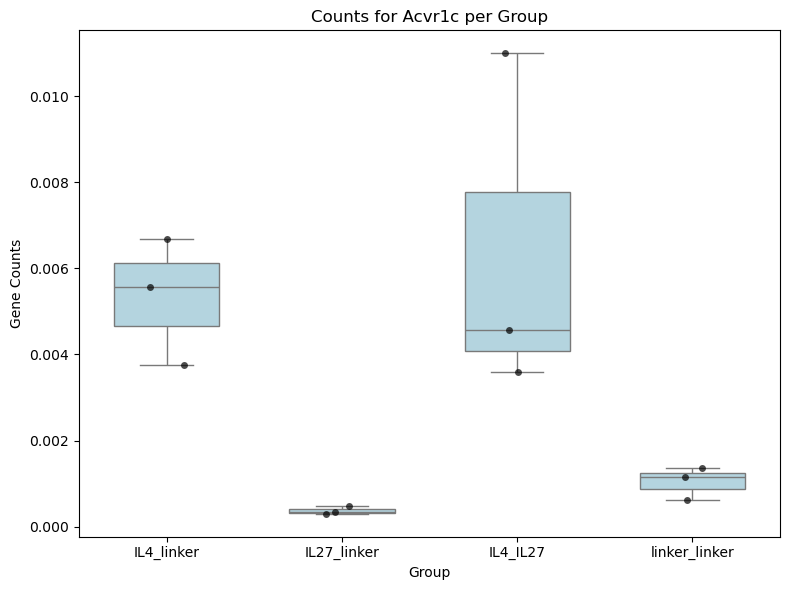

,Group,Count
0,IL4_linker,0.006676
1,IL4_linker,0.003763
2,IL4_linker,0.005578
3,IL27_linker,0.000488
4,IL27_linker,0.000304
5,IL27_linker,0.000336
6,IL4_IL27,0.004571
7,IL4_IL27,0.003601
8,IL4_IL27,0.010997
9,linker_linker,0.001356


In [146]:
plot_gene_counts_boxplot(adataPB,"IL4","IL27","Acvr1c")